# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

In [3]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

# Select only players with a salary cap percentage in the interquartile range
q1 = test_train_data['SALARY CAP PERCENTAGE'].quantile(0.25)
q3 = test_train_data['SALARY CAP PERCENTAGE'].quantile(0.75)
iqr = q3 - q1

# # Remove outliers
# test_train_data = test_train_data[(test_train_data['SALARY CAP PERCENTAGE'] >= q1 - 1.5 * iqr) & (test_train_data['SALARY CAP PERCENTAGE'] <= q3 + 1.5 * iqr)]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0005058431793367282


In [14]:
# Perform Grid Search to find the optimal parameters
param_grid = {
    'regressor__n_estimators': [500, 1000, 1500],
    'regressor__max_depth': [5, 10, 15],
    'regressor__reg_lambda': [.1, 1, 10],
    'regressor__eta': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.score(X_test, y_test))


/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [4]:
# Assuming your pipeline is named 'pipeline' and has been fitted

# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print the sorted feature importances
# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance}")

# If you have a large number of features and only want to see the top ones, you can slice the list
print("Top 10 most important features:")
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance}")


Top 10 most important features:
XGF/GP: 0.07755807787179947
TOI/GP: 0.07129288464784622
SF/GP: 0.06810401380062103
OFF. ZONE FACEOFFS/GP: 0.028182070702314377
FF/GP: 0.023224076256155968
DEF. ZONE FACEOFFS/GP: 0.018137553706765175
XGA/GP: 0.017279760912060738
SCA/GP: 0.012967166490852833
PIM/GP: 0.012245651334524155
FIRST ASSISTS/GP: 0.012013825587928295


In [5]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [6]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [7]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
11557,erik karlsson,2022-23,"$11,500,000.00","$11,457,202.00","$-42,798.00",0.138875
439,zdeno chara,2007-08,"$7,500,000.00","$6,908,290.00","$-591,710.00",0.137342
10662,erik karlsson,2021-22,"$11,500,000.00","$10,965,212.00","$-534,788.00",0.134542
12390,erik karlsson,2023-24,"$11,500,000.00","$10,848,768.00","$-651,232.00",0.129925
5162,p.k. subban,2014-15,"$9,000,000.00","$8,893,803.00","$-106,197.00",0.128896
1616,zdeno chara,2009-10,"$7,500,000.00","$7,035,431.00","$-464,569.00",0.123863
3599,ryan suter,2012-13,"$7,538,462.00","$7,353,625.00","$-184,837.00",0.122560
6019,p.k. subban,2015-16,"$9,000,000.00","$8,652,669.00","$-347,331.00",0.121186
8997,erik karlsson,2019-20,"$11,500,000.00","$9,839,140.00","$-1,660,860.00",0.120726
80,chris pronger,2007-08,"$6,250,000.00","$6,062,846.00","$-187,154.00",0.120534


In [8]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
8869,cale makar,2019-20,"$2,854,166.00","$4,006,094.00","$1,151,928.00",0.049155
9676,cale makar,2020-21,"$2,854,166.00","$1,416,439.00","$-1,437,727.00",0.017380
10529,cale makar,2021-22,"$9,000,000.00","$7,263,888.00","$-1,736,112.00",0.089127
11430,cale makar,2022-23,"$9,000,000.00","$9,102,255.00","$102,255.00",0.110330
12280,cale makar,2023-24,"$9,000,000.00","$8,851,974.00","$-148,026.00",0.106012


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

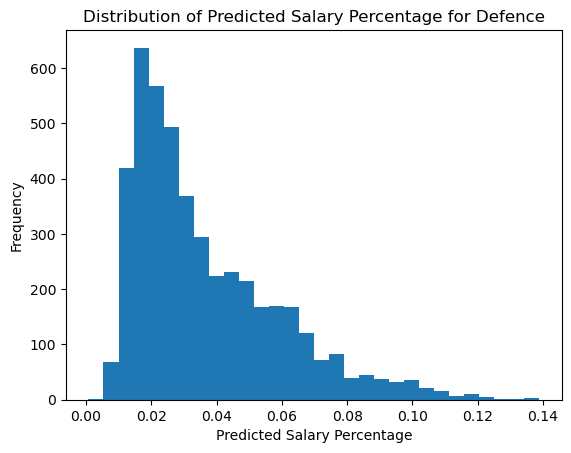

In [9]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Centers')

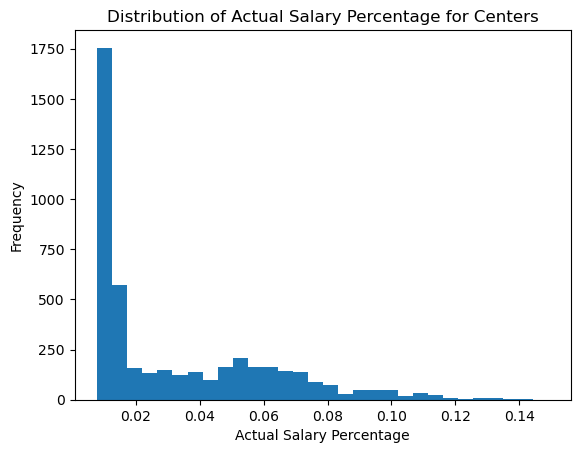

In [10]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Centers')

In [11]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12273,min,brock faber,2023-24,"$1,008,333.00","$5,274,337.00","$4,266,004.00",0.063166,4266004.0
12731,nyi,noah dobson,2023-24,"$4,000,000.00","$6,705,142.00","$2,705,142.00",0.080301,2705142.0
12780,buf,rasmus dahlin,2023-24,"$6,000,000.00","$8,103,333.00","$2,103,333.00",0.097046,2103333.0
12370,wpg,dylan demelo,2023-24,"$3,000,000.00","$5,044,036.00","$2,044,036.00",0.060408,2044036.0
12839,ari,sean durzi,2023-24,"$1,700,000.00","$3,220,531.00","$1,520,531.00",0.038569,1520531.0
12472,dal,jani hakanpää,2023-24,"$1,500,000.00","$2,966,276.00","$1,466,276.00",0.035524,1466276.0
12921,edm,vincent desharnais,2023-24,"$762,500.00","$1,990,764.00","$1,228,264.00",0.023841,1228264.0
12458,min,jake middleton,2023-24,"$2,450,000.00","$3,631,712.00","$1,181,712.00",0.043494,1181712.0
12430,ari,j.j. moser,2023-24,"$925,000.00","$2,079,581.00","$1,154,581.00",0.024905,1154581.0
12462,ott,jakob chychrun,2023-24,"$4,600,000.00","$5,646,315.00","$1,046,315.00",0.067621,1046315.0


In [12]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12723,"cgy, van",nikita zadorov,2023-24,"$3,750,000.00","$3,342,363.00","$-407,637.00",0.040028,-407637.0
12809,nsh,ryan mcdonagh,2023-24,"$6,750,000.00","$6,328,095.00","$-421,905.00",0.075786,-421905.0
12707,wsh,nick jensen,2023-24,"$4,050,000.00","$3,578,199.00","$-471,801.00",0.042853,-471801.0
12603,n.j,luke hughes,2023-24,"$1,850,000.00","$1,337,850.00","$-512,150.00",0.016022,-512150.0
12451,cbj,jake bean,2023-24,"$2,333,333.00","$1,814,992.00","$-518,341.00",0.021736,-518341.0
12654,edm,mattias ekholm,2023-24,"$6,250,000.00","$5,668,687.00","$-581,313.00",0.067888,-581313.0
12886,phi,travis sanheim,2023-24,"$6,250,000.00","$5,654,283.00","$-595,717.00",0.067716,-595717.0
12390,pit,erik karlsson,2023-24,"$11,500,000.00","$10,848,768.00","$-651,232.00",0.129925,-651232.0
12538,col,josh manson,2023-24,"$4,500,000.00","$3,816,398.00","$-683,602.00",0.045705,-683602.0
12241,car,brady skjei,2023-24,"$5,250,000.00","$4,547,626.00","$-702,374.00",0.054463,-702374.0
